In [12]:
import os
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import load_model
from pathlib import Path
import numpy as np

In [13]:
#dataset pre-processing
BATCH_SIZE = 32
img_size = (224,224)
#training data generator
traingen = ImageDataGenerator(       rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)

#test dataset generator
testgen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
#dataset path for training and testing data
path_to_training_data = 'E:/ambience_mode/dataset/train'
path_to_testing_data = 'E:/ambience_mode/dataset/test'

#class labels
labels = os.listdir(path_to_training_data)
#training data
training_data = traingen.flow_from_directory(  path_to_training_data,
                                               target_size=img_size,
                                               class_mode='categorical',
                                               classes=labels,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)
#validation data
validation_data = traingen.flow_from_directory(path_to_training_data,
                                               target_size=img_size,
                                               class_mode='categorical',
                                               classes=labels,
                                               subset='validation',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

#testing data
testing_data = testgen.flow_from_directory(    path_to_testing_data,
                                               target_size=img_size,
                                               class_mode=None,
                                               classes=labels,
                                               batch_size=1, 
                                               shuffle=False,
                                               seed=42)

Found 1275 images belonging to 5 classes.
Found 223 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [28]:
#base model attributes
input_shape = (224,224,3)

base_model = MobileNetV2(include_top=False,
            weights='imagenet', 
            input_shape=input_shape)

In [29]:
base_model.summary()

for layer in base_model.layers[:-3]:
    layer.trainable=False

base_model.summary()

#base_model.layers[:-2]

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [38]:
#top of the model
inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.1)(x)  
#outputs = keras.layers.Dense(1)(x)
outputs = Dense(5, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [39]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 418,565
Non-trainable params: 1,845,824
___________________________________________

In [40]:
model_path = 'E:/ambience_mode/new metrics'


In [41]:

from keras.callbacks import ModelCheckpoint, EarlyStopping
top_weights_path = os.path.join(os.path.abspath(model_path), 'new_best_model_weights_2.h5')
callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=0)
    ]


In [42]:
optmzr = Adam(learning_rate=0.0003)
model.compile(optimizer=optmzr, loss='categorical_crossentropy',
                  metrics=['accuracy'])
history = model.fit(training_data, epochs=20, steps_per_epoch=BATCH_SIZE, validation_data=validation_data,callbacks=callbacks_list)

Epoch 1/20
32/32 [==============================] - 172s 5s/step - loss: 1.5151 - accuracy: 0.4407 - val_loss: 0.7538 - val_accuracy: 0.7040

Epoch 00001: val_accuracy improved from -inf to 0.70404, saving model to E:\ambience_mode\new metrics\new_best_model_weights_2.h5


c:\users\raihan\anaconda3\envs\obj_detection\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
32/32 [==============================] - 140s 4s/step - loss: 0.7099 - accuracy: 0.7333 - val_loss: 0.7163 - val_accuracy: 0.7354

Epoch 00002: val_accuracy improved from 0.70404 to 0.73543, saving model to E:\ambience_mode\new metrics\new_best_model_weights_2.h5
Epoch 3/20
32/32 [==============================] - 138s 4s/step - loss: 0.6314 - accuracy: 0.7742 - val_loss: 0.5971 - val_accuracy: 0.7758

Epoch 00003: val_accuracy improved from 0.73543 to 0.77578, saving model to E:\ambience_mode\new metrics\new_best_model_weights_2.h5
Epoch 4/20
32/32 [==============================] - 139s 4s/step - loss: 0.5218 - accuracy: 0.7977 - val_loss: 0.5235 - val_accuracy: 0.8161

Epoch 00004: val_accuracy improved from 0.77578 to 0.81614, saving model to E:\ambience_mode\new metrics\new_best_model_weights_2.h5
Epoch 5/20
32/32 [==============================] - 139s 4s/step - loss: 0.4693 - accuracy: 0.8395 - val_loss: 0.5073 - val_accuracy: 0.8117

Epoch 00005: val_accuracy did not

In [44]:
import matplotlib.pyplot as plt

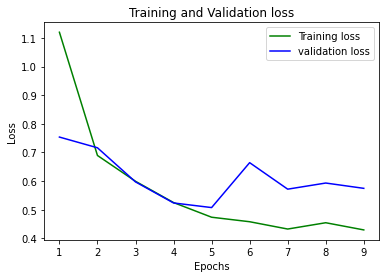

In [46]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,10)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

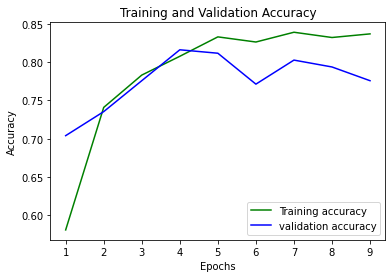

In [47]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,10)
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
import cv2
import numpy as np

In [51]:
img = cv2.imread('E:/ambience_mode/new_test/rain_5.jpg')
img = cv2.resize(img,(224,224))
img = np.array(img)
print(img[0][0][0])
img = (img/255)*2-1 #does the exact same thing as preprocess_input function of MobilenetV2 which is essential for preprocessing
img = np.around(img,decimals=7)
img = np.expand_dims(img,axis=0)

42


In [52]:
model.predict(img)

array([[0.01894912, 0.88721395, 0.6627052 , 0.21248317, 0.6223766 ]],
      dtype=float32)

In [253]:
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
print(vgg_pred_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
